# Customer Lifetime Value Prediction

### CLTV = Conditional Expected Number of Transaction * Conditional Expected Average Profit

First, the whole customers' behaviours are applied to a model and then make prediction the expected transaction for each customer.

### CLTV = BG/NBD MODEL * GAMMA GAMMA SUBMODEL
BG/NBD MODEL for expected number of transaction
GAMMA GAMMA SUBMODEL for expected average profit

BG/NBD MODEL : Beta Geometric / Negative Binomial Distribution

### Transaction Process(buy)

- Possion distribution for the expected number of transaction and transaction rate
- Gamma distribution in whole customers 

### Dropout Process(till you die)
	
- All customers have their dropout probability as p. 
- Beta distribution for dropout rates




## Importing Modules & Dataset


In [55]:
pip install lifetimes

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [56]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [57]:
data2010 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2009-2010")
data2011 = pd.read_excel("online_retail_II.xlsx", sheet_name="Year 2010-2011")

In [58]:
data = data2010.append(data2011)
data.reset_index(drop = True, inplace=True)
df = data.copy()

## Exploratory Data Analysis

### Check Data

In [59]:
def check(df, head = 5):
    print("**********************************HEAD**********************************")
    print(df.head(head))
    print("**********************************TAIL**********************************")
    print(df.tail(head))
    print("**********************************TYPES**********************************")
    print(df.dtypes)
    print("**********************************SHAPE**********************************")
    print(df.shape)
    print("**********************************NA**********************************")
    print(df.isnull().sum())
    print("**********************************QUANTILES**********************************")
    print(df.describe([0, 0.05, 0.5, 0.95]))

In [60]:
check(df)

**********************************HEAD**********************************
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00 6.9500   13085.0000  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00 6.7500   13085.0000  United Kingdom
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00 6.7500   13085.0000  United Kingdom
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00 2.1000   13085.0000  United Kingdom
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24 2009-12-01 07:45:00 1.2500   13085.0000  United Kingdom
**********************************TAIL**********************************
        Invoice StockCode                      Description  Quantity         InvoiceDate   Price  Customer ID Countr

### Grab Columns

In [61]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [62]:
cats,nums,cards = grab_col_names(df)

Observations: 1067371
Variables: 8
cat_cols: 0
num_cols: 4
cat_but_car: 4
num_but_cat: 0


In [63]:
def num_summary(df, col, plot=False):
    quantiles = [0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 0.95, 0.99]
    print(df[col].describe(quantiles).T)
    print("*****************************************************")
    if plot:
        df[col].hist()
        plt.xlabel(col)
        plt.title(col)
        plt.show(block=True)
        
        

count   1067371.0000
mean          9.9389
std         172.7058
min      -80995.0000
1%           -3.0000
5%            1.0000
10%           1.0000
25%           1.0000
50%           3.0000
75%          10.0000
95%          30.0000
99%         100.0000
max       80995.0000
Name: Quantity, dtype: float64
*****************************************************


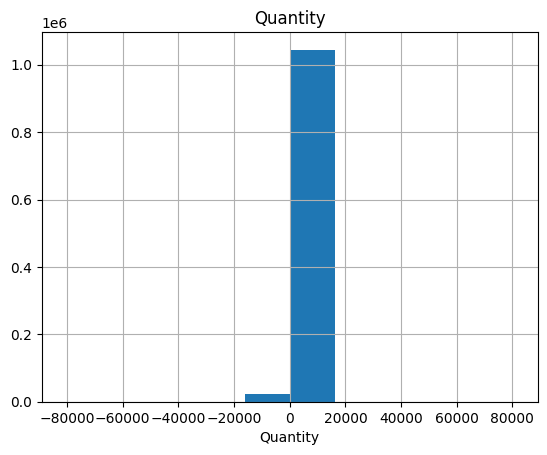

count                 1067371
unique                  47635
top       2010-12-06 16:57:00
freq                     1350
first     2009-12-01 07:45:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object
*****************************************************


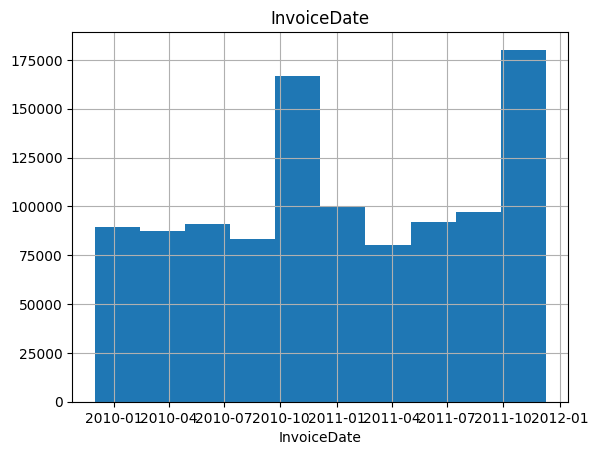

count   1067371.0000
mean          4.6494
std         123.5531
min      -53594.3600
1%            0.2100
5%            0.4200
10%           0.6500
25%           1.2500
50%           2.1000
75%           4.1500
95%           9.9500
99%          18.0000
max       38970.0000
Name: Price, dtype: float64
*****************************************************


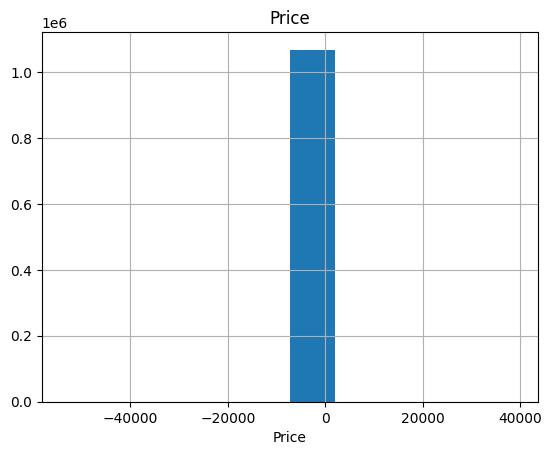

count   824364.0000
mean     15324.6385
std       1697.4645
min      12346.0000
1%       12422.0000
5%       12681.0000
10%      12971.0000
25%      13975.0000
50%      15255.0000
75%      16797.0000
95%      17911.0000
99%      18207.0000
max      18287.0000
Name: Customer ID, dtype: float64
*****************************************************


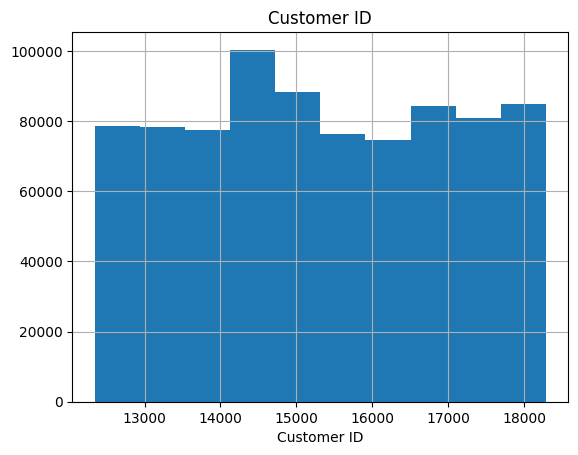

In [64]:
for col in nums:
    num_summary(df,col,plot=True)


### Handling Missing Values


There are missing values in two columns which are Description and Customer ID. The number of missing values in the Description column is not significant amount and the situation of being missing values in the unique Customer ID column can not be accepted, thus we drop these missing values for better analysis.  

In [65]:
data.dropna(inplace=True)

In [66]:
data.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

### Handling Outliers

  There are significantly huge value of outliers in Quantity and Price columns, so we need to fix that problem by measuring IQR and make the data between Q1 - 1.5IQR and Q3 + 1.5IQR.
  We do not take any action about the values in quantity and price which are lower than zero because they may be returned products and/or promoted products and our main target is not analyze the customers intent like in market basket analysis. 

In [67]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,824364.0000,12.4146,188.9761,-80995.0000,2.0000,5.0000,12.0000,80995.0000
Price,824364.0000,3.6768,70.2414,0.0000,1.2500,1.9500,3.7500,38970.0000
Customer ID,824364.0000,15324.6385,1697.4645,12346.0000,13975.0000,15255.0000,16797.0000,18287.0000


In [68]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [69]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")


count   824364.0000
mean        12.4146
std        188.9761
min     -80995.0000
1%          -2.0000
5%           1.0000
10%          1.0000
25%          2.0000
50%          5.0000
75%         12.0000
95%         36.0000
99%        120.0000
max      80995.0000
Name: Quantity, dtype: float64
*****************************************************


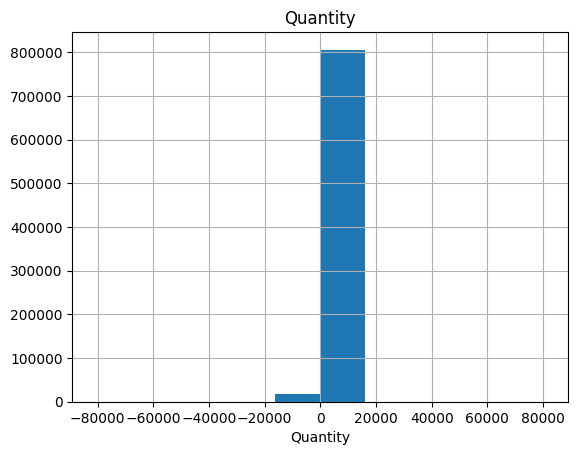

count                  824364
unique                  41439
top       2011-11-14 15:27:00
freq                      543
first     2009-12-01 07:45:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object
*****************************************************


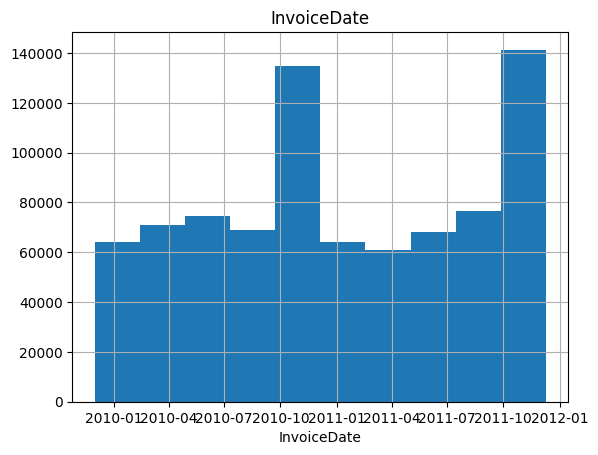

count   824364.0000
mean         3.6768
std         70.2414
min          0.0000
1%           0.2900
5%           0.4200
10%          0.5500
25%          1.2500
50%          1.9500
75%          3.7500
95%          8.5000
99%         14.9500
max      38970.0000
Name: Price, dtype: float64
*****************************************************


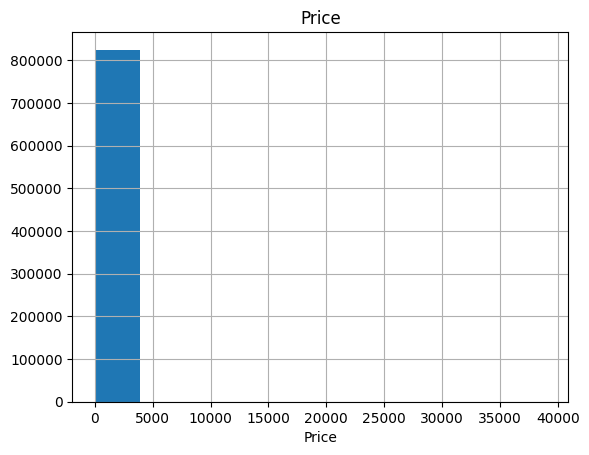

count   824364.0000
mean     15324.6385
std       1697.4645
min      12346.0000
1%       12422.0000
5%       12681.0000
10%      12971.0000
25%      13975.0000
50%      15255.0000
75%      16797.0000
95%      17911.0000
99%      18207.0000
max      18287.0000
Name: Customer ID, dtype: float64
*****************************************************


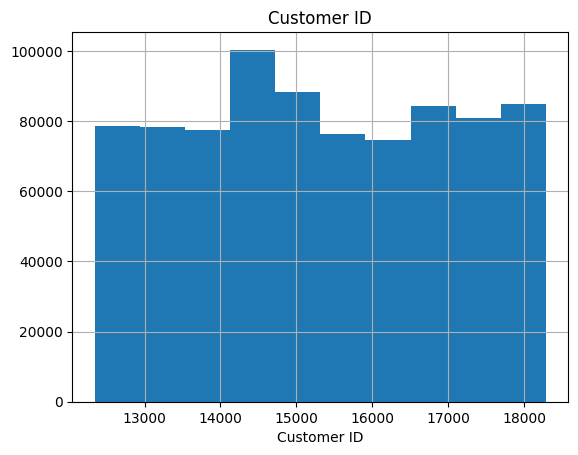

In [70]:
for col in nums:
    num_summary(data,col,True)

## Data Preprocessing & Analyzing

In [71]:
#Creating new column
df["TotalPrice"] = df["Quantity"] * df["Price"]
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [72]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0000,2009-12-01 07:45:00,6.9500,13085.0000,United Kingdom,83.4000
1,489434,79323P,PINK CHERRY LIGHTS,12.0000,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000
2,489434,79323W,WHITE CHERRY LIGHTS,12.0000,2009-12-01 07:45:00,6.7500,13085.0000,United Kingdom,81.0000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0000,2009-12-01 07:45:00,2.1000,13085.0000,United Kingdom,100.8000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0000,2009-12-01 07:45:00,1.2500,13085.0000,United Kingdom,30.0000


In [73]:
#Calculation of the metrics
today_date = dt.datetime(2011, 12, 11)
cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (today_date - InvoiceDate.max()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice': lambda Invoice: Invoice.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [74]:

cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

In [75]:
#Average Basket Amount
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [76]:
#Turn the metrics into weekly basis
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

cltv_df["recency"] = cltv_df["recency"] / 7

cltv_df["T"] = cltv_df["T"] / 7

In [77]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,46.5714,103.7143,12,53.1283
12347.0000,0.4286,57.8571,8,704.1650
12348.0000,10.8571,62.7143,5,403.8800
12349.0000,2.7143,84.2857,4,953.1862
12352.0000,5.2857,56.1429,10,214.3595


### BG-NBD Model

In [78]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])


<lifetimes.BetaGeoFitter: fitted with 4255 subjects, a: 1.35, alpha: 0.04, b: 7.03, r: 0.27>

In [79]:
#The top 10 customers of number of transaction in weekly period
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
16000.0000   4.1205
15060.0000   2.0316
18139.0000   1.7582
16479.0000   1.0729
12452.0000   0.7274
17509.0000   0.7112
17100.0000   0.6569
14785.0000   0.6471
17523.0000   0.6254
13596.0000   0.5618
dtype: float64

In [80]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [81]:
#The top 10 customers of the number of  transaction in monthly period 
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
16000.0000   9.0786
15060.0000   5.7106
18139.0000   5.4096
16479.0000   3.3004
17509.0000   2.5505
12452.0000   2.4001
17100.0000   2.2017
14785.0000   2.1164
17523.0000   2.0078
17461.0000   1.8311
dtype: float64

In [82]:

cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [83]:
#The total expected transaction number of the company in 3 months
bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

680.0972237740743

In [84]:
cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

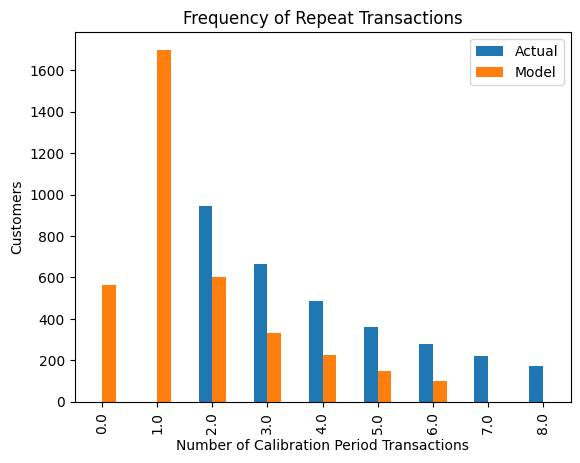

In [85]:
# Evaluating the results
plot_period_transactions(bgf)
plt.show()

### Gamma Gamma Submodel

In [86]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [87]:
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 4255 subjects, p: 3.80, q: 0.34, v: 3.74>

In [89]:
#The top 10 customers in total revenue for company
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

Customer ID
12357.0000   6185.2939
12590.0000   5016.3660
12415.0000   4961.3301
14091.0000   4501.4793
14088.0000   4032.7224
12753.0000   3678.2182
18102.0000   3444.1212
12409.0000   3430.9196
14646.0000   3279.3499
14096.0000   3202.2186
dtype: float64

In [90]:
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

### Combining The BG-NBD MODEL And Gamma Gamma Submodel

In [91]:
#CLTV Prediction for 3 Months
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  
                                   freq="W",  
                                   discount_rate=0.01)

In [92]:
cltv.head()

Customer ID
12346.0000   0.0564
12347.0000   0.0000
12348.0000   0.3393
12349.0000   0.0021
12352.0000   0.0000
Name: clv, dtype: float64

In [93]:
cltv = cltv.reset_index()

In [94]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
2615,16000.0000,0.4286,0.4286,3,2089.3067,4.1205,9.0786,13.4083,2218.4541,29995.0359
4157,18139.0000,2.5714,2.7143,6,1406.3900,1.7582,5.4096,10.4627,1448.7768,15521.1957
3726,17509.0000,8.2857,9.1429,8,764.3925,0.7112,2.5505,6.0747,781.7620,4939.1082
135,12536.0000,6.2857,8.5714,3,1456.3600,0.2617,0.9672,2.4388,1546.7840,3944.2379
169,12590.0000,30.2857,30.2857,2,4580.6850,0.0636,0.2493,0.7106,5016.3660,3773.5291
3431,17100.0000,2.7143,2.7143,2,485.8700,0.6569,2.2017,4.7850,533.9144,2639.1485
2890,16376.0000,1.2857,2.5714,2,493.5050,0.4515,1.5020,3.2323,542.2722,1809.3789
2438,15749.0000,33.7143,47.5714,3,2582.3267,0.0468,0.1842,0.5309,2741.6369,1542.8322
2207,15427.0000,4.8571,6.8571,3,494.3800,0.3138,1.1398,2.7869,525.9505,1528.3605
1297,14164.0000,10.1429,11.5714,2,815.8850,0.1565,0.5950,1.5864,895.1704,1492.8404


In [95]:
#Creating Segments by CLV

cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

In [96]:
cltv_final.sort_values(by="clv", ascending=False).head(50)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
2615,16000.0000,0.4286,0.4286,3,2089.3067,4.1205,9.0786,13.4083,2218.4541,29995.0359,A
4157,18139.0000,2.5714,2.7143,6,1406.3900,1.7582,5.4096,10.4627,1448.7768,15521.1957,A
3726,17509.0000,8.2857,9.1429,8,764.3925,0.7112,2.5505,6.0747,781.7620,4939.1082,A
135,12536.0000,6.2857,8.5714,3,1456.3600,0.2617,0.9672,2.4388,1546.7840,3944.2379,A
169,12590.0000,30.2857,30.2857,2,4580.6850,0.0636,0.2493,0.7106,5016.3660,3773.5291,A
3431,17100.0000,2.7143,2.7143,2,485.8700,0.6569,2.2017,4.7850,533.9144,2639.1485,A
2890,16376.0000,1.2857,2.5714,2,493.5050,0.4515,1.5020,3.2323,542.2722,1809.3789,A
2438,15749.0000,33.7143,47.5714,3,2582.3267,0.0468,0.1842,0.5309,2741.6369,1542.8322,A
2207,15427.0000,4.8571,6.8571,3,494.3800,0.3138,1.1398,2.7869,525.9505,1528.3605,A
1297,14164.0000,10.1429,11.5714,2,815.8850,0.1565,0.5950,1.5864,895.1704,1492.8404,A


In [97]:
cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})

Customer ID                     recency                        T               frequency                  monetary                expected_purc_1_week              expected_purc_1_month              expected_purc_3_month              expected_average_profit                        clv               
                  sum       mean count        sum    mean count        sum    mean count       sum    mean count         sum     mean count                  sum   mean count                   sum   mean count                   sum   mean count                     sum     mean count         sum     mean count
segment                                                                                                                                                                                                                                                                                                              
D       16317850.0000 15336.3252  1064  3400.4286  3.1959  1064 96904.0000 91.0752  1064     21810 20.4981  1064 454160.9877 426.8430  1064               0.0000 0.0000  1064                0.0000 0.0000  1064                0.0000 0.0000  1064             460034.7932 432.3635  1064      0.0000   0.0000  1064
C       16294068.0000 15313.9737  1064  8798.2857  8.2691  1064 79935.4286 75.1273  1064      6584  6.1880  1064 367841.4446 345.7156  1064               0.0145 0.0000  1064                0.0570 0.0001  1064                0.1636 0.0002  1064             380826.9388 357.9201  1064     42.8510   0.0403  1064
B       16338423.0000 15370.1063  1063 29438.2857 27.6936  1063 75774.2857 71.2834  1063      3873  3.6435  1063 312326.6697 293.8162  1063               7.8260 0.0074  1063               30.8114 0.0290  1063               89.1323 0.0838  1063             332100.4014 312.4181  1063  16758.6244  15.7654  1063
A       16193025.0000 15219.0085  1064 45397.1429 42.6665  1064 63993.0000 60.1438  1064      3079  2.8938  1064 413538.9962 388.6645  1064              63.2372 0.0594  1064              228.4424 0.2147  1064              590.8013 0.5553  1064             446052.4077 419.2222  1064 263302.2272 247.4645  1064

## Functionalize The Process

In [101]:
def create_cltv_p(dataframe, month=3):
    # Data Preprocessing
    dataframe.dropna(inplace=True)
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7

    # 2. BG-NBD Model
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    # 3. GAMMA-GAMMA Model
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # 4. Combining BG-NBD and GG Model to predict CLV .
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=month,  # 3 aylık
                                       freq="W",  # T'nin frekans bilgisi.
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

    return cltv_final


In [99]:
df_ = df.copy()

In [102]:
cltv_final2 = create_cltv_p(df_)


In [104]:
cltv_final2.head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
0,12346.0000,57.1429,103.7143,12,53.1283,0.0055,0.0218,0.0648,54.2218,3.7407,D
1,12347.0000,57.4286,57.8571,8,704.1650,0.1369,0.5451,1.6158,720.2019,1237.4221,A
2,12348.0000,51.7143,62.7143,5,398.3720,0.0825,0.3286,0.9748,413.4202,428.6010,B
3,12349.0000,81.4286,84.2857,4,946.6250,0.0571,0.2276,0.6769,990.3800,713.1391,A
4,12352.0000,50.8571,56.1429,10,209.8940,0.1651,0.6572,1.9474,213.9688,443.0700,B
5,12353.0000,29.1429,58.4286,2,203.3800,0.0369,0.1471,0.4364,224.6801,104.2838,C
6,12355.0000,50.4286,81.1429,2,473.8050,0.0318,0.1269,0.3775,520.7020,209.1268,C
7,12356.0000,57.2857,60.7143,6,1062.2800,0.1026,0.4087,1.2122,1094.4496,1410.8477,A
8,12357.0000,50.7143,55.5714,3,5824.8667,0.0660,0.2629,0.7793,6182.5152,5123.2102,A
9,12358.0000,104.2857,104.5714,5,770.6820,0.0560,0.2234,0.6653,799.0689,565.6139,B


In [106]:
#Exporting the final dataframe
cltv_final2.to_csv("cltv_prediction.csv")